#**Modelado de la serie de tiempo usando métodos de Aprendizaje Automático**

### **Preparar el notebook**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

In [ ]:
from xgboost import XGBRegressor

### **Cargar los datos preparados**

In [ ]:
#dfsuro = pd.read_csv('/content/drive/MyDrive/ProyectoIntegrador2/datos_suroeste.csv')
dfsuro = pd.read_csv('/content/datos_suroeste.csv')

In [ ]:
print(dfsuro.shape)
dfsuro.head()

(4117, 16)


,Unnamed: 0,ID,ELEMENTO,NODO,FECHA,COORD_LONG,COORD_LAT,REGION,SUBREGION,GRUPO_RESPONSABLE,CRITICIDAD_NUM,MUNICIPIO,CIRCUITO,PENDIENTE,ESTADO,tipo
0,3,14962964.0,FR46394,NaN,2023-02-10 20:34:35,-76.031442,6.135418,SUROESTE,AMAGA,DE25,64.0,5847.0,507-12,TRABAJOS DE PODA,CERRADA,OT
1,10,4946322.0,F54128,NaN,2021-02-27 16:17:36,-75.949641,6.176642,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT
2,11,11918713.0,FR5175,NaN,2022-08-05 07:22:47,-75.945599,6.222647,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT
3,153,13222653.0,FR5144,553018.0,2022-10-14 16:36:05,-75.990291,6.171016,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT
4,156,4916076.0,F54165,NaN,2021-02-20 14:04:59,-75.918451,5.997762,SUROESTE,AMAGA,DE25,64.0,5209.0,518-13,TRABAJOS DE PODA,CANCELADA,OT


In [ ]:
dfsuro.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
# Dar formato al campo FECHA
dfsuro['FECHA'] = pd.to_datetime(dfsuro['FECHA'], format='%Y-%m-%d %H:%M:%S.%f')
# Dar formato al campo ID
dfsuro['ID'] = dfsuro['ID'].astype(int)

In [ ]:
dfsuro.dtypes

ID                            int64
ELEMENTO                     object
NODO                        float64
FECHA                datetime64[ns]
COORD_LONG                  float64
COORD_LAT                   float64
REGION                       object
SUBREGION                    object
GRUPO_RESPONSABLE            object
CRITICIDAD_NUM              float64
MUNICIPIO                   float64
CIRCUITO                     object
PENDIENTE                    object
ESTADO                       object
tipo                         object
dtype: object

### **Análisis de la serie de tiempo con frecuencia semanal**

In [ ]:
dfsuro['fecha_semana'] = pd.to_datetime(dfsuro['FECHA']).dt.to_period('W')

In [ ]:
dfsuro.head()

,ID,ELEMENTO,NODO,FECHA,COORD_LONG,COORD_LAT,REGION,SUBREGION,GRUPO_RESPONSABLE,CRITICIDAD_NUM,MUNICIPIO,CIRCUITO,PENDIENTE,ESTADO,tipo,fecha_semana
0,14962964,FR46394,NaN,2023-02-10 20:34:35,-76.031442,6.135418,SUROESTE,AMAGA,DE25,64.0,5847.0,507-12,TRABAJOS DE PODA,CERRADA,OT,2023-02-06/2023-02-12
1,4946322,F54128,NaN,2021-02-27 16:17:36,-75.949641,6.176642,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT,2021-02-22/2021-02-28
2,11918713,FR5175,NaN,2022-08-05 07:22:47,-75.945599,6.222647,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT,2022-08-01/2022-08-07
3,13222653,FR5144,553018.0,2022-10-14 16:36:05,-75.990291,6.171016,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT,2022-10-10/2022-10-16
4,4916076,F54165,NaN,2021-02-20 14:04:59,-75.918451,5.997762,SUROESTE,AMAGA,DE25,64.0,5209.0,518-13,TRABAJOS DE PODA,CANCELADA,OT,2021-02-15/2021-02-21


Se extrae la serie semanal, haciendo el conteo de eventos de Trabajos de Poda generados por semana

In [ ]:
serie_suro = pd.DataFrame(dfsuro.groupby(['fecha_semana'])['ID'].count())

Se obtiene una serie con 182 observaciones

In [ ]:
print(serie_suro.shape)

(182, 1)


Se renombra la columna para mayor claridad

In [ ]:
serie_suro.rename(columns={'ID':'CANT_EVENTOS'},inplace=True)

In [ ]:
serie_suro.head()

,CANT_EVENTOS
fecha_semana,
2019-10-28/2019-11-03,1
2019-11-04/2019-11-10,4
2019-11-11/2019-11-17,6
2019-11-18/2019-11-24,12
2019-11-25/2019-12-01,9


In [ ]:
serie_suro.dtypes

CANT_EVENTOS    int64
dtype: object

<Axes: xlabel='fecha_semana'>

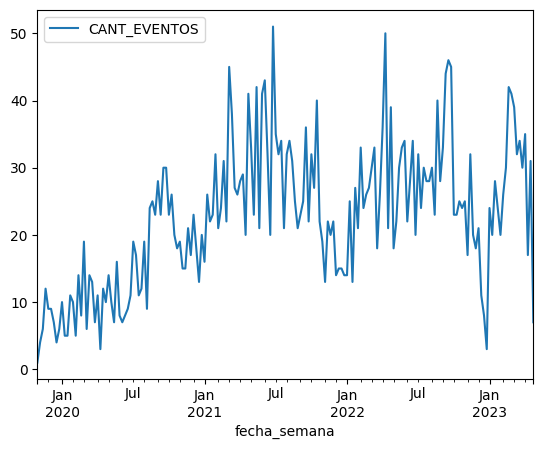

In [ ]:
serie_suro.plot()

Se observa en la gráfica una tendencia creciente en la cantidad de eventos registrados. Esto se debe a un subregistro de los eventos en la etapa inicial de estabilización del sistema donde se almacenan los datos. Con el fin de evitar sesgos en las estimaciones se eliminarán los registros correspondientes a este periodo de estabilización

In [ ]:
#Seleccionamos los datos de la serie que se usarán.
serie_suro=serie_suro.iloc[44:-1]
serie_suro

,CANT_EVENTOS
fecha_semana,
2020-08-31/2020-09-06,28
2020-09-07/2020-09-13,23
2020-09-14/2020-09-20,30
2020-09-21/2020-09-27,30
2020-09-28/2020-10-04,23
...,...
2023-03-13/2023-03-19,34
2023-03-20/2023-03-26,30
2023-03-27/2023-04-02,35


<Axes: xlabel='fecha_semana'>

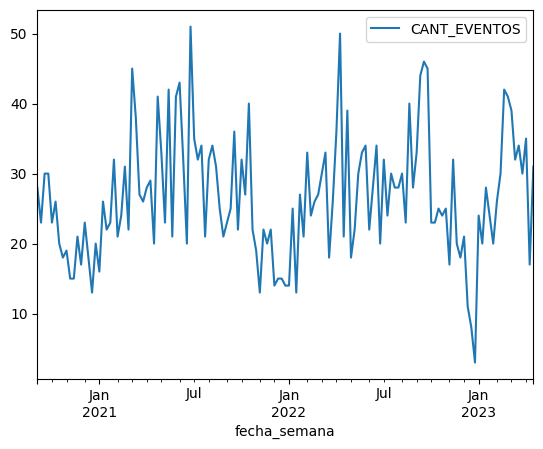

In [ ]:
serie_suro.plot()

####**Transformación del conjunto de datos e incorporación de otras variables**


Se realiza una transformación de los datos para convertirlos a una estructura que facilite la aplicació de los modelos de aprendizaje automático

En primer lugar se modifica el índice de la serie de tiempo, correspondiente a un rango semanal, conservando únicamente la fecha inicial.

In [ ]:
serie_suro.index = serie_suro.index.to_timestamp()

In [ ]:
serie_suro.CANT_EVENTOS

fecha_semana
2020-08-31    28
2020-09-07    23
2020-09-14    30
2020-09-21    30
2020-09-28    23
              ..
2023-03-13    34
2023-03-20    30
2023-03-27    35
2023-04-03    17
2023-04-10    31
Freq: W-MON, Name: CANT_EVENTOS, Length: 137, dtype: int64

 Se crea una variable *dummy* que refleje la condición de indisponibilidad del sistema de información donde se crean los eventos y se almacenan los datos (fechas donde han ocurrido este tipo de situaciones).

In [ ]:
#Se crea sobre el dataframe original una variable dummy con valor 1 
#para las fechas donde se tiene conocimiento de situaciones de indisponibilidad del sistema de información
dummy = np.where(serie_suro.index.isin(['2022-12-19 00:00:00', '2022-12-12 00:00:00', '2022-12-05 00:00:00']), 1, 0)
serie_suro['dummy'] = dummy

<ipython-input-24-a89ad3de393f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie_suro['dummy'] = dummy


**Datos de precipitaciones**

Como parte del entendimiento del negocio, se ha identificado una posible relación entre la cantidad de precipitaciones en la zona geográfica de estudio y la generación de eventos de poda en las redes de distribución.

Considerando lo anterior, se ha determinado incluir en el modelado los datos de precipitaciones capturados por cuatro estaciones de monitoreo ubicadas en la región en interés.

In [ ]:
#Carga de los datos
#df = pd.read_csv('/content/drive/MyDrive/ProyectoIntegrador2/Precipitaciones/precipitacion_suroeste.csv', encoding='latin-1')
df = pd.read_csv('/content/precipitacion_suroeste.csv', encoding='latin-1')

In [ ]:
precipitacion=df[['NombreEstacion','Fecha','Valor']]
precipitacion['Fecha'] = pd.to_datetime(precipitacion['Fecha'])
precipitacion

<ipython-input-26-f854ac561c41>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precipitacion['Fecha'] = pd.to_datetime(precipitacion['Fecha'])


,NombreEstacion,Fecha,Valor
0,BOLOMBOLO [26200130],2020-08-24,24.7
1,BOLOMBOLO [26200130],2020-08-25,0.0
2,BOLOMBOLO [26200130],2020-08-26,2.7
3,BOLOMBOLO [26200130],2020-08-27,0.0
4,BOLOMBOLO [26200130],2020-08-28,2.4
...,...,...,...
3849,URRAO [11075020],2023-04-12,4.5
3850,URRAO [11075020],2023-04-13,12.5
3851,URRAO [11075020],2023-04-14,0.0
3852,URRAO [11075020],2023-04-15,1.2


In [ ]:
#Obtener la serie de datos para cada una de las estaciones de monitoreo
bolombolo=precipitacion[precipitacion['NombreEstacion']=='BOLOMBOLO [26200130]']
santabarbara=precipitacion[precipitacion['NombreEstacion']=='SANTA BARBARA [26190100]']
fredonia=precipitacion[precipitacion['NombreEstacion']=='FREDONIA [26200150]']
urrao=precipitacion[precipitacion['NombreEstacion']=='URRAO [11075020]']

In [ ]:
#Agrupar los datos de precipitaciones en forma semanal 
#con el fin de darles la misma periodicidad de muestreo de la serie de datos de eventos
bolombolo_semanal = bolombolo.groupby([pd.Grouper(key='Fecha', freq='W')])['Valor'].sum()
santabarbara_semanal = santabarbara.groupby([pd.Grouper(key='Fecha', freq='W')])['Valor'].sum()
fredonia_semanal = fredonia.groupby([pd.Grouper(key='Fecha', freq='W')])['Valor'].sum()
urrao_semanal = urrao.groupby([pd.Grouper(key='Fecha', freq='W')])['Valor'].sum()

In [ ]:
#Se adicionan los datos de precipitaciones al dataframe original
serie_suro['bolombolo'] = bolombolo_semanal[1:].values
serie_suro['santabarbara'] = santabarbara_semanal[1:].values
serie_suro['fredonia'] = fredonia_semanal[1:].values
serie_suro['urrao'] = urrao_semanal[1:].values

<ipython-input-29-a3830f9f264e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie_suro['bolombolo'] = bolombolo_semanal[1:].values
<ipython-input-29-a3830f9f264e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie_suro['santabarbara'] = santabarbara_semanal[1:].values
<ipython-input-29-a3830f9f264e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

**Adicionar el trimestre como variable predictora para modelar la estacionalidad de los datos**

In [ ]:
serie_suro['trimestre'] = serie_suro.index.quarter

<ipython-input-30-ded73e068546>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie_suro['trimestre'] = serie_suro.index.quarter


In [ ]:
df_one_hot = pd.get_dummies(serie_suro['trimestre'], prefix='trimestre')
df_one_hot

,trimestre_1,trimestre_2,trimestre_3,trimestre_4
fecha_semana,,,,
2020-08-31,0,0,1,0
2020-09-07,0,0,1,0
2020-09-14,0,0,1,0
2020-09-21,0,0,1,0
2020-09-28,0,0,1,0
...,...,...,...,...
2023-03-13,1,0,0,0
2023-03-20,1,0,0,0
2023-03-27,1,0,0,0


In [ ]:
serie_suro = pd.concat([serie_suro, df_one_hot], axis=1)

In [ ]:
serie_suro.drop('trimestre', axis = 1, inplace=True)

Ahora el conjunto de datos se compone de:
* la cantidad de eventos de poda ocurridos
* las precipitaciones registradas por las estaciones de monitoreo en la zona de interés
* la condición de indisponibilidad del sistema de información donde se registran los eventos
* el trimestre correspondiente a la fechas del registro

In [ ]:
serie_suro.tail()

,CANT_EVENTOS,dummy,bolombolo,santabarbara,fredonia,urrao,trimestre_1,trimestre_2,trimestre_3,trimestre_4
fecha_semana,,,,,,,,,,
2023-03-13,34,0,68.0,63.0,112.0,24.7,1,0,0,0
2023-03-20,30,0,0.0,19.8,13.0,3.1,1,0,0,0
2023-03-27,35,0,2.4,49.2,45.0,14.4,1,0,0,0
2023-04-03,17,0,5.4,76.5,26.0,1.0,0,1,0,0
2023-04-10,31,0,20.8,59.9,27.0,30.2,0,1,0,0


**Dividir el conjunto de datos en set de entrenamiento y set de prueba**

In [ ]:
#se define el número de periodos que serán usados como conjunto de datos de entrenamiento

Ntest = 12
data_train = serie_suro.iloc[:-Ntest]
data_test = serie_suro.iloc[-Ntest:]

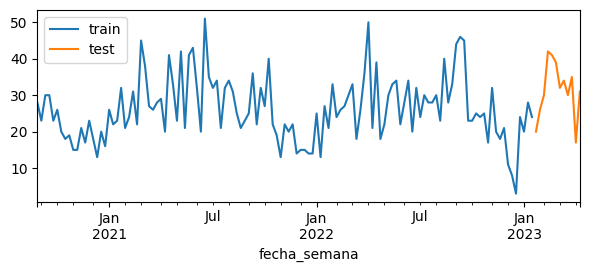

In [ ]:
#Gráfica de los conjuntos de datos de entrenamiento y de prueba

fig, ax = plt.subplots(figsize=(7, 2.5))
data_train['CANT_EVENTOS'].plot(ax=ax, label='train')
data_test['CANT_EVENTOS'].plot(ax=ax, label='test')
ax.legend();

### **Modelos de aprendizaje automático**

####**Random Forest**

Crear y entrenar el modelo autorregresivo que utilizará como predictores rezagos de la propia variable que se quiere predecir.
El modelo además utilizará como predictores otras variables (variables exógenas) cuyo valor puede conocerse: la cantidad de precipitaciones en la región.

In [ ]:
columnas = list(data_train.columns)
columnas[1:]

['dummy',
 'bolombolo',
 'santabarbara',
 'fredonia',
 'urrao',
 'trimestre_1',
 'trimestre_2',
 'trimestre_3',
 'trimestre_4']

In [ ]:
#Se define el modelo 
forecaster_RF = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags= 3)

#Se ajusta el modelo sobre el conjunto de datos de entrenamiento
forecaster_RF.fit(y=data_train['CANT_EVENTOS'], exog=data_train[columnas[1:]])
forecaster_RF

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3] 
Transformer for y: None 
Transformer for exog: None 
Window size: 3 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['dummy', 'bolombolo', 'santabarbara', 'fredonia', 'urrao', 'trimestre_1', 'trimestre_2', 'trimestre_3', 'trimestre_4'] 
Training range: [Timestamp('2020-08-31 00:00:00'), Timestamp('2023-01-16 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-MON 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
C

In [ ]:
#Se hace la predicción de los valores para el conjunto de datos de entrenamiento
predictions_RF = forecaster_RF.predict(steps=Ntest, exog=data_test[columnas[1:]])

**Gráfica del resultado del modelo Random Forest**

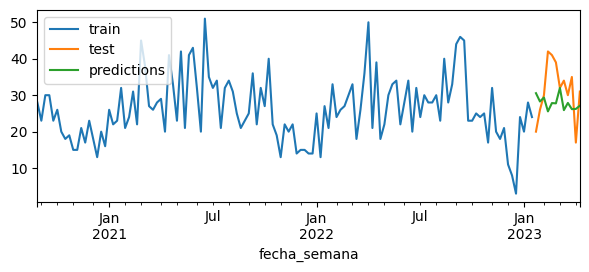

In [ ]:
fig, ax = plt.subplots(figsize=(7, 2.5))
data_train['CANT_EVENTOS'].plot(ax=ax, label='train')
data_test['CANT_EVENTOS'].plot(ax=ax, label='test')
predictions_RF.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
error_mse_RF = mean_squared_error(
                y_true = data_test['CANT_EVENTOS'],
                y_pred = predictions_RF
            )

print(f"Test error (rmse): {np.sqrt(error_mse_RF)}")

Test error (rmse): 8.826492319526862


**Hiperametrización del modelo**




El modelo anterior usa 3 rezagos y los parámetros por defecto del modelo Random Forest. Sin embargo, con el fin de identificar la mejor combinación de hiperparámetros, se ejecuta una función de *gridsearch*, la cual compara los resultados obtenidos con cada configuración presentada usando backtesting.

In [ ]:
#Se define el modelo con unos parámetros iniciales
forecaster_RF = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 3 # This value will be replaced in the grid search
             )

#Se definen el conjunto de valores a probar
lags_grid = [3, 4, 5]
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'criterion' :['squared_error', 'friedman_mse']}

#Se define la función de gridsearch
results_grid_RF = grid_search_forecaster(
                    forecaster  = forecaster_RF,
                    y           = data_train['CANT_EVENTOS'],
                    exog        = data_train[columnas[1:]],
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    steps       = 12,
                    refit       = True,
                    metric      = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    return_best = True,
                    verbose     = False
               )

Number of models compared: 54.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/18 [00:00<?, ?it/s]

params grid:   0%|          | 0/18 [00:00<?, ?it/s]

params grid:   0%|          | 0/18 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'criterion': 'squared_error', 'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 62.42092871058832



In [ ]:
results_grid_RF.head()

,lags,params,mean_squared_error,criterion,max_depth,n_estimators
39,"[1, 2, 3, 4, 5]","{'criterion': 'squared_error', 'max_depth': 5,...",62.420929,squared_error,5,50
48,"[1, 2, 3, 4, 5]","{'criterion': 'friedman_mse', 'max_depth': 5, ...",62.420929,friedman_mse,5,50
9,"[1, 2, 3]","{'criterion': 'friedman_mse', 'max_depth': 3, ...",63.906317,friedman_mse,3,50
0,"[1, 2, 3]","{'criterion': 'squared_error', 'max_depth': 3,...",63.909069,squared_error,3,50
10,"[1, 2, 3]","{'criterion': 'friedman_mse', 'max_depth': 3, ...",63.985469,friedman_mse,3,100


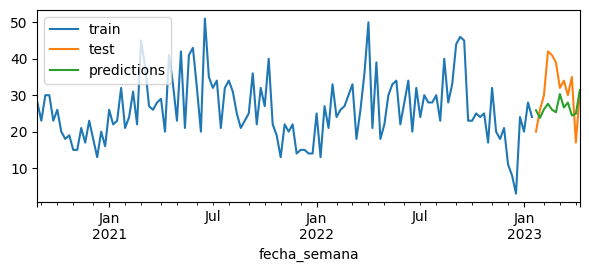

In [ ]:
predictions_RF = forecaster_RF.predict(steps=Ntest, exog=data_test[columnas[1:]])

fig, ax = plt.subplots(figsize=(7, 2.5))
data_train['CANT_EVENTOS'].plot(ax=ax, label='train')
data_test['CANT_EVENTOS'].plot(ax=ax, label='test')
predictions_RF.plot(ax=ax, label='predictions')
ax.legend();

**Error de la predicción en el conjunto de prueba**

In [ ]:
error_mse_RF = mean_squared_error(y_true = data_test['CANT_EVENTOS'], y_pred = predictions_RF)
error_mae_RF = mean_absolute_error(y_true = data_test['CANT_EVENTOS'], y_pred = predictions_RF)

print('Error de la predicción')
print(f"Test error (rmse): {np.sqrt(error_mse_RF)}")
print(f"Test error (mae): {error_mae_RF}")

Error de la predicción
Test error (rmse): 8.693786382058363
Test error (mae): 7.079540371283268


**Crear dataframe para almacenar los resultados de la predicción**

In [ ]:
forecast = serie_suro[['CANT_EVENTOS']]

In [ ]:
predictions_RF = pd.Series(predictions_RF, name='pred_RF')

In [ ]:
predictions_RF

2023-01-23    25.881980
2023-01-30    23.766302
2023-02-06    26.118676
2023-02-13    27.642955
2023-02-20    26.048954
2023-02-27    25.305571
2023-03-06    30.311085
2023-03-13    26.625605
2023-03-20    27.971852
2023-03-27    24.441763
2023-04-03    24.882428
2023-04-10    31.422839
Freq: W-MON, Name: pred_RF, dtype: float64

In [ ]:
forecast = forecast.merge(predictions_RF, how = 'left', left_index = True, right_index = True)

In [ ]:
forecast.tail()

,CANT_EVENTOS,pred_RF
fecha_semana,,
2023-03-13,34,26.625605
2023-03-20,30,27.971852
2023-03-27,35,24.441763
2023-04-03,17,24.882428
2023-04-10,31,31.422839


####**XGboost**

In [ ]:
serie_suro.head()

,CANT_EVENTOS,dummy,bolombolo,santabarbara,fredonia,urrao,trimestre_1,trimestre_2,trimestre_3,trimestre_4
fecha_semana,,,,,,,,,,
2020-08-31,28,0,43.3,44.5,73.0,63.6,0,0,1,0
2020-09-07,23,0,34.3,24.6,124.0,16.8,0,0,1,0
2020-09-14,30,0,37.8,44.4,77.0,55.9,0,0,1,0
2020-09-21,30,0,71.7,39.9,67.0,12.7,0,0,1,0
2020-09-28,23,0,78.3,47.0,130.0,64.1,0,0,1,0


**Dividir el conjunto de datos para el modelo**

Con el fin de buscar los hiperparámetros óptimos del modelo y evaluar su capacidad predictiva, los datos serán divididos en tres subconjuntos separados: entrenamiento, validación y prueba.

In [ ]:
#Se tomarán 12 datos para el subconjuto de pruebas
#Se tomarán 12 datos para el subconjuto de validación

NTest = 12 ## Posición del "punto de corte" para el subconjunto de prueba. 
Nval = 24 ## Posición del "punto de corte" para el subconjunto de validación

data_train = serie_suro.iloc[: -Nval, :]
data_val   = serie_suro.iloc[-Nval:-NTest, :]
data_test  = serie_suro.iloc[-NTest:, :]

print(f"fechas entrenamiento      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"fechas validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"fechas prueba       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


fechas entrenamiento      : 2020-08-31 00:00:00 --- 2022-10-24 00:00:00  (n=113)
fechas validacion : 2022-10-31 00:00:00 --- 2023-01-16 00:00:00  (n=12)
fechas prueba       : 2023-01-23 00:00:00 --- 2023-04-10 00:00:00  (n=12)


**Gráfica de la serie de tiempo**

Se grafica la serie de datos, con la división en los conjuntos de entrenamiento, validación y prueba

In [ ]:
import plotly.express as px
serie_suro.loc[:-Nval, 'partition'] = 'train'
serie_suro.loc[-Nval:-NTest, 'partition'] = 'validation'
serie_suro.loc[-NTest:, 'partition'] = 'test'

fig = px.line(
    data_frame = serie_suro.reset_index(),
    x      = 'fecha_semana',
    y      = 'CANT_EVENTOS',
    color  = 'partition',
    title  = 'Number of users',
    width  = 800,
    height = 450
)
fig.update_layout(
    width  = 800,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()
data=serie_suro.drop(columns='partition')

<ipython-input-54-4e2be630b1ca>:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  serie_suro.loc[:-Nval, 'partition'] = 'train'
<ipython-input-54-4e2be630b1ca>:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  serie_suro.loc[-Nval:-NTest, 'partition'] = 'validation'
<ipython-input-54-4e2be630b1ca>:4: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  serie_suro.loc[-NTest:, 'partition'] = 'test'


**Crear y entrenar el modelo**

Crear y entrenar el modelo autorregresivo que utilizará como predictores los rezagos de la propia variable que se quiere predecir.
El modelo además utilizará como predictores otras variables (variables exógenas) cuyo valor puede conocerse: la cantidad de precipitaciones en la región.

In [ ]:
#Se define el modelo 
forecaster_XG = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags = 3
             )

In [ ]:
#definir lista con las variables exógenas
exog_features = columnas[1:]

**Hiperparametrización del modelo**

Con el fin de identificar la mejor combinación de hiperparámetros, se ejecuta una función de *gridsearch*, la cual compara los resultados obtenidos con cada configuración presentada usando *backtesting*.

* El modelo se entrena usando el conjunto de entrenamiento unicamente.
* El modelo se evalúa usando *backtesting*
* Se selecciona la combinación de hiperparámetros y rezagos que generen el menor error.

In [ ]:
#Se definen el conjunto de valores a probar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1]}

lags_grid = [3, 4, 5]

#Se define la función de gridsearch
results_grid_XG = grid_search_forecaster(
                   forecaster         = forecaster_XG,
                   y                  = serie_suro.loc[:'2023-01-16 00:00:00', 'CANT_EVENTOS'], # Train and validation data
                   exog               = serie_suro.loc[:'2023-01-16 00:00:00', exog_features ],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 4,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data_train), # Model is trained with training data
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 81.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/27 [00:00<?, ?it/s]

params grid:   0%|          | 0/27 [00:00<?, ?it/s]

params grid:   0%|          | 0/27 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
  Backtesting metric: 43.478358318559536



In [ ]:
results_grid_XG.head()

,lags,params,mean_squared_error,learning_rate,max_depth,n_estimators
40,"[1, 2, 3, 4]","{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",43.478358,0.05,4.0,100.0
41,"[1, 2, 3, 4]","{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",44.503252,0.05,4.0,200.0
51,"[1, 2, 3, 4]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",45.508501,0.10,5.0,50.0
48,"[1, 2, 3, 4]","{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",46.646956,0.10,4.0,50.0
37,"[1, 2, 3, 4]","{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",47.453655,0.05,3.0,100.0


**Hacer la predicción sobre el conjunto de prueba y calcular el error de la predicción**

Una vez se ha identificado la mejor combinación de hiperparámetros usando el conjunto de validación, la capacidad predictiva del modelo se evalúa sobre el conjunto de prueba usando *backtesting*.

In [ ]:
# Backtesting on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster_XG,
                            y                  = serie_suro['CANT_EVENTOS'],
                            initial_train_size = len(data.loc[:'2023-01-16 00:00:00']),
                            fixed_train_size   = False,
                            steps              = 4,
                            refit              = False,
                            metric             = 'mean_squared_error',
                            verbose            = False # Change to True to see detailed information
                      )        

print(f"Backtest error - MSE: {metric:.2f}")
predictions

  0%|          | 0/3 [00:00<?, ?it/s]

Backtest error - MSE: 67.46


,pred
2023-01-23,28.008787
2023-01-30,25.728933
2023-02-06,27.223480
2023-02-13,28.586107
2023-02-20,26.593563
2023-02-27,27.296806
2023-03-06,31.622663
2023-03-13,28.127460
2023-03-20,37.130043
2023-03-27,33.618713


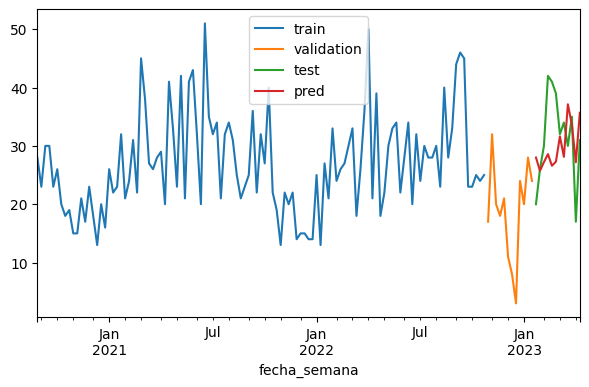

In [ ]:
# Graficar los resultados de la predicción

fig, ax = plt.subplots(figsize=(7, 4))
data_train['CANT_EVENTOS'].plot(ax=ax, label='train')
data_val['CANT_EVENTOS'].plot(ax=ax, label='validation')
data_test['CANT_EVENTOS'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

**Error de la predicción en el conjunto de prueba**

In [ ]:
error_mse_XG = mean_squared_error(y_true = data_test['CANT_EVENTOS'], y_pred = predictions)
error_mae_XG = mean_absolute_error(y_true = data_test['CANT_EVENTOS'], y_pred = predictions)

print('Error de la predicción en el conjunto de prueba')
print(f"Test error (rmse): {np.sqrt(error_mse_XG)}")
print(f"Test error (mae): {error_mae_XG}")


Error de la predicción en el conjunto de prueba
Test error (rmse): 8.213576043109246
Test error (mae): 6.684592564900716


**Almacenar los resultados de la predicción**




In [ ]:
forecast = forecast.merge(predictions, how = 'left', left_index = True, right_index = True)

In [ ]:
forecast.rename(columns={'pred':'pred_XGBoost'},inplace=True)

In [ ]:
forecast.tail(13)

,CANT_EVENTOS,pred_RF,pred_XGBoost
fecha_semana,,,
2023-01-16,24,NaN,NaN
2023-01-23,20,25.881980,28.008787
2023-01-30,26,23.766302,25.728933
2023-02-06,30,26.118676,27.223480
2023-02-13,42,27.642955,28.586107
2023-02-20,41,26.048954,26.593563
2023-02-27,39,25.305571,27.296806
2023-03-06,32,30.311085,31.622663
2023-03-13,34,26.625605,28.127460


**Exportar los datos y resultados obtenidos**

In [ ]:
#forecast.to_csv('/content/drive/MyDrive/ProyectoIntegrador2/datos_export/forecast_ML.csv')